In [1]:
import sys
import os

# Insert the parent directory of "app" into sys.path
# so that Python recognizes "app" as an importable package.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)

In [2]:
from dotenv import load_dotenv
load_dotenv()  # This looks for .env in the current working directory

True

In [3]:
import time

import pandas as pd
import seaborn as sns
from datasets import Dataset
from ragas import evaluate
from ragas.llms import LlamaIndexLLMWrapper
from ragas.metrics import (
    answer_relevancy,
    context_precision,
    context_recall,
    faithfulness,
)
from llama_index.llms.openai import OpenAI
from tqdm import tqdm

from workflows.shared import graph_store


/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAIBase has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAICommon has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [6]:
# Import flows
from workflows.naive_text2cypher import NaiveText2CypherFlow
from workflows.naive_text2cypher_retry import NaiveText2CypherRetryFlow
#from workflows.iterative_planner import IterativePlanningFlow

In [9]:
from llama_index.utils.workflow import (
    draw_all_possible_flows,
)

# Draw all
draw_all_possible_flows(NaiveText2CypherRetryFlow(), filename=f"{NaiveText2CypherRetryFlow.__name__}.html")

<class 'NoneType'>
<class 'app.workflows.naive_text2cypher_retry.ExecuteCypherEvent'>
<class 'app.workflows.naive_text2cypher_retry.SummarizeEvent'>
<class 'app.workflows.naive_text2cypher_retry.CorrectCypherEvent'>
<class 'app.workflows.naive_text2cypher_retry.ExecuteCypherEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
NaiveText2CypherRetryFlow.html


In [5]:
# Benchmark data
test_df = pd.read_csv('test_data.csv', delimiter=";")
test_df.head()

,Question,Cypher
0,Who acted in Tom Hanks’s highest-rated movie?,MATCH (p:Person {name: 'Tom Hanks'})-[:ACTED_I...
1,Which movie starring Keanu Reeves has the most...,"MATCH (meg:Actor {name: ""Keanu Reeves""})-[:ACT..."
2,Who directed the most recent movie starring Ha...,"MATCH (p:Person {name: ""Halle Berry""})-[:ACTED..."
3,What is the highest-rated movie from the 1990s...,MATCH (m:Movie)-[:DIRECTED]-(d:Person) WHERE m...
4,"For all movies starring Keanu Reeves, find the...","MATCH (keanu:Person {name: ""Keanu Reeves""})-[:..."


In [6]:
# Instantiate flow
flow = NaiveText2CypherFlow(timeout=60)

In [7]:
# Get workflows generated answers
results = []
latencies = []
ground_truth = []
for i, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing questions"):
    question = row['Question']
    start = time.time()
    try:
        data = await flow.run(input=question)
    except:
        data = {"answer": "timeout", "question": question}
    end = time.time()
    latencies.append(end - start)
    results.append(data)
    try:
        ground_truth.append(graph_store.structured_query(row['Cypher']))
    except Exception as e:
        ground_truth.append("missing")

Processing questions: 100%|██████████| 50/50 [09:05<00:00, 10.91s/it]


In [8]:
# Convert to DataFrame
df = pd.DataFrame(results)
df["ground_truth"] = [str(el) for el in ground_truth]  # Dates are causing troubles
df["latency"] = latencies
# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
df.head()

,cypher,question,answer,ground_truth,latency
0,MATCH (p:Person {name: 'Tom Hanks'})-[:ACTED_I...,Who acted in Tom Hanks’s highest-rated movie?,"Based on the context provided, the actor who a...","[{'a.name': 'David Andrews', 'm.title': 'From ...",8.189747
1,MATCH (keanu:Person {name: 'Keanu Reeves'})-[:...,Which movie starring Keanu Reeves has the most...,"Based on the context provided, the movie starr...","[{'Movie': 'Lake House, The', 'CommonActors': 2}]",8.595193
2,"MATCH (p:Person {name: ""Halle Berry""})-[:ACTED...",Who directed the most recent movie starring Ha...,"The most recent movie starring Halle Berry, as...","[{'director': 'Brad Anderson', 'mostRecentMovi...",12.128535
3,MATCH (m:Movie)-[:DIRECTED]-(d:Person) \nWHERE...,What is the highest-rated movie from the 1990s...,"The highest-rated movie from the 1990s is **""T...","[{'highestRatedMovie': 'Shawshank Redemption, ...",8.023361
4,MATCH (keanu:Person {name: 'Keanu Reeves'})-[:...,"For all movies starring Keanu Reeves, find the...","Based on the context provided, the director wh...","[{'director': 'Lana Wachowski', 'collaboration...",9.239155


In [9]:
result = evaluate(
    dataset,
    metrics=[
        answer_relevancy
    ],
    llm=LlamaIndexLLMWrapper(OpenAI(model="gpt-4o-2024-11-20", temperature=0))
)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
result

{'answer_relevancy': 0.6025}

In [11]:
result_df = result.to_pandas()
result_df.to_csv('benchmark_output.csv', index=False)

<Axes: xlabel='answer_relevancy', ylabel='Count'>

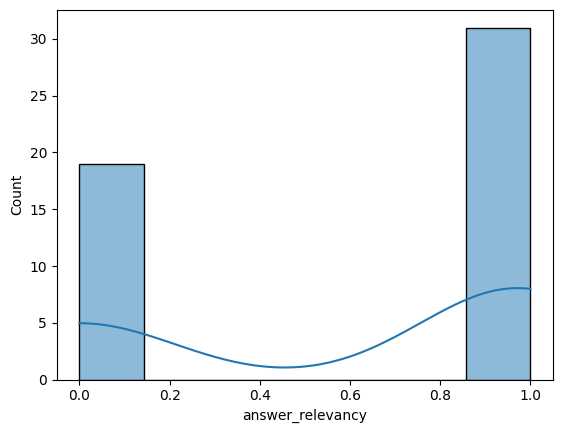

In [12]:
sns.histplot(result_df['answer_relevancy'], kde=True)

<Axes: xlabel='latency', ylabel='Count'>

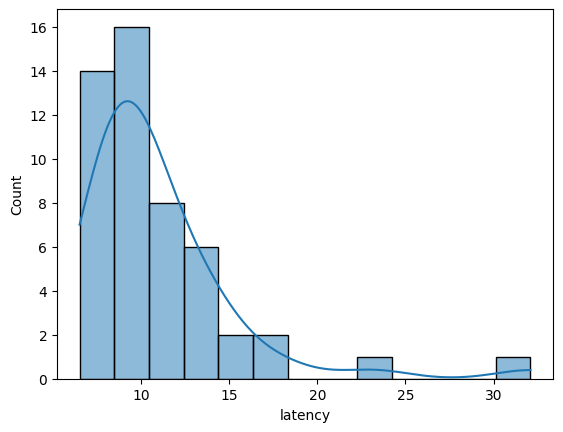

In [14]:
sns.histplot(df['latency'], kde=True)